Last updated: February 2, 2025

This notebook requires a GPU that is not available on the free option of Colab.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iris-lew/projects/blob/main/project_006_AES/AES_5_model_no_custom.ipynb)

In this notebook, I am using the same model as my previous notebook (AES_2_model_no_custom.ipynb), but I am going to be using a custom loss function. The custom loss function is a smooth (differentiable) version of the quadratic weighted kappa (AES_4_custom_loss_function.ipynb). The quadratic weighted kappa is a metric that was used in the [original ASAP-AES competition](https://www.kaggle.com/c/asap-aes) and it measures the agreement between the two raters. It goes from 0 to 1 with 0 meaning random agreement and 1 meaning complete agreement. My theory is that if I used this as a loss function and I try to minimize the inverse (thus more agreement), then I would achieve a higher accuracy.

There is a difference between a loss function and a metric. It'd be great if the model can directly optimize on the metric, but that's not always possible if the metric is not differentiable. As the quadratic weighted kappa is not differentiable, a smooth version needed to be created. Since I adapted the code from a [medium article](https://medium.com/@wenmin_wu/directly-optimize-quadratic-weighted-kappa-with-tf2-0-482cf0318d74), I need to verify that my adaptation of it is actually a quadratic weighted kappa.

As I was working on developing the custom loss function and using it in the model, the validation loss was the same while the training loss fluctuated. This signals that the function is working, but the model is memorizing answers. I updated the batch size to see if this would fix the problem, but it did not. This means I should continue working on the loss function to see if there is another problem.

As it is a custom loss function, I need to assign gradients to the loss function, and not the model. I shouldn't be updating the gradients in the model or else it'd be a combination of the old gradients (model) and the new loss gradients (loss), thus pointing to another minimum. When assigning gradients, the GPU usage will increase and will go beyond the free tier of Google Colab.

I reset the global variables setting multiple times throughout my code because I kept moving back and forth in the workbook and needed to ensure I could achieve the same result.

# Libraries, Datasets, and Custom Functions

In [ ]:
### only used for Google Colab
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
%cd data

/content/gdrive/MyDrive/data


In [ ]:
# libraries
import numpy as np
import pandas as pd

import random
from sklearn.utils import shuffle

import time
import datetime

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import TFAutoModel, AutoTokenizer
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn
from typing import Optional

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
asap_train = pd.read_csv('training_set_rel3.tsv', sep='\t', header=0, encoding="ISO-8859-1")

ell_train = pd.read_csv("ELLIPSE_Final_github_train.csv")
ell_test = pd.read_csv("ELLIPSE_Final_github_test.csv")

ell_train_fin = ell_train[ell_train['grade']<=10]
ell_test_fin = ell_test[ell_test['grade']<=10]

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
indices = list(range(asap_train.shape[0]))
random.shuffle(indices)
cutoff1 = 0.8*asap_train.shape[0]
cutoff1 = int(round(cutoff1,0))
cutoff2 = 0.9*asap_train.shape[0]
cutoff2 = int(round(cutoff2,0))

train_indices = indices[0:cutoff1]
val_indices = indices[cutoff1:cutoff2]
test_indices = indices[cutoff2:]

x_train = asap_train.iloc[train_indices,]["essay"]
y_train = asap_train.iloc[train_indices,]["domain1_score"]

x_val = asap_train.iloc[val_indices,]["essay"]
y_val = asap_train.iloc[val_indices,]["domain1_score"]

x_test = asap_train.iloc[test_indices,]["essay"]
y_test = asap_train.iloc[test_indices,]["domain1_score"]

In [ ]:
x_test_ell = ell_test_fin['full_text']

# Tokenizing & Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
input_ids = []
attention_masks = []

for essay in x_train:
    encoded_dict = tokenizer.encode_plus(
                        essay,
                        add_special_tokens = True,
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [ ]:
input_ids_test = []
attention_masks_test = []

for essay in x_test:
    encoded_dict = tokenizer.encode_plus(
                        essay,
                        add_special_tokens = True,
                        max_length = 512,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids_test.append(encoded_dict['input_ids'])

    attention_masks_test.append(encoded_dict['attention_mask'])

input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

In [ ]:
input_ids_ell = []
attention_masks_ell = []

for essay in x_test_ell:
    encoded_dict = tokenizer.encode_plus(
                        essay,
                        add_special_tokens = True,
                        max_length = 512,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids_ell.append(encoded_dict['input_ids'])
    attention_masks_ell.append(encoded_dict['attention_mask'])

input_ids_ell = torch.cat(input_ids_ell, dim=0)
attention_masks_ell = torch.cat(attention_masks_ell, dim=0)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
labels = torch.tensor(y_train.values)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,342 training samples
1,039 validation samples


In [ ]:
num_outputs_possible_d1 = max(max(y_train),max(y_test))+1
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = num_outputs_possible_d1,
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 2e-5,
                              eps = 1e-8
                              )

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


This is the custom loss function. The hypothesis is that this will lead to higher accuracy due to optimizing on a more suitable loss function.

In [ ]:
class WeightedKappaLoss(nn.Module):
  """
  """
  def __init__(
      self,
      num_classes: int,
      epsilon: Optional[float]= 1e-10):

    """
    """
    super(WeightedKappaLoss, self).__init__()
    self.num_classes = num_classes
    self.epsilon = epsilon

  def kappa_loss(self, y_pred, y_true):
    num_classes = self.num_classes

    label_vec = torch.arange(start=0, end=num_classes).type(torch.float32).to(device)
    row_label_vec = torch.reshape(label_vec, [1, num_classes]).to(device)
    col_label_vec = torch.reshape(label_vec, [num_classes, 1]).to(device)

    y_true = y_true.float().to(device)
    y_true_hist = torch.histc(y_true, bins=num_classes, min=0, max=num_classes) # i added this in. this is histogram of true values.
    labels = torch.matmul(y_true_hist, col_label_vec) # this becomes one number: tensor([278.])


    a = torch.tile(labels, [1, num_classes]) # updated it to be num_classes instead of the shape of y_true
    b = torch.tile(row_label_vec, [num_classes,1]) # updated it to be num_classes instead of the shape of y_true
    c = torch.tile(col_label_vec, [1, num_classes])


    weight = torch.pow(a - b,2).to(device)
    weight = torch.div(weight, (num_classes-1)**2) # (61,61) matrix

    weight_mat = torch.div(torch.pow(c-b,2),((num_classes-1)**2)) # (61,61) matrix

    y_pred_hist = torch.histc(y_pred, bins=num_classes, min=0, max=num_classes) # i added this in. this is histogram of predicted values.
    d = weight*y_pred_hist # (61,61) matrix

    numerator = torch.sum(d) # originally tf.reduce_sum

    f = torch.matmul(weight_mat, y_pred_hist) # originally tf.reduce_sum # shape is 61
    denominator = torch.matmul(y_true_hist,f)
    denominator = torch.div(denominator, num_classes)

    return torch.log(numerator / denominator + self.epsilon)

  def forward(self, y_pred, y_true):
    return self.kappa_loss(y_pred,y_true)


loss_fn = WeightedKappaLoss(
    num_classes = num_outputs_possible_d1
)

Run up to here for batch-size, and then jump to the "Updating Batch-Size section". This is because even with an A100 GPU, it's not large enough to hold the model and gradients in memory.

# `domain1_score` Model

In [ ]:
batch_size = 32

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [ ]:
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
training_stats = []

for epoch_i in range(0, epochs):
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        modt = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        logits=modt['logits']
        most_likely = torch.argmax(logits, dim=1).flatten()
        most_likely = most_likely.float()
        most_likely.requires_grad = True
        b_labels = b_labels.long()
        loss = loss_fn(most_likely, b_labels)
        loss.requires_grad = True
        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            modv = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            logits = modv['logits']
            most_likely = torch.argmax(logits, dim=1).flatten()
            most_likely = most_likely.float()
            most_likely.requires_grad = True
            b_labels = b_labels.long()
            loss = loss_fn(most_likely, b_labels)
            # loss.requires_grad = True

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print("  Validation Loss: {0:.5f}".format(avg_val_loss))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss
        }
    )

print("")
print("Training complete!")


  Average training loss: 7.91174
  Validation Loss: 7.41172

  Average training loss: 7.93640
  Validation Loss: 7.41172

  Average training loss: 7.93706
  Validation Loss: 7.41172

Training complete!


In [ ]:
pd.set_option('display.precision', 5)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss
epoch,,
1,7.91174,7.41172
2,7.93640,7.41172
3,7.93706,7.41172


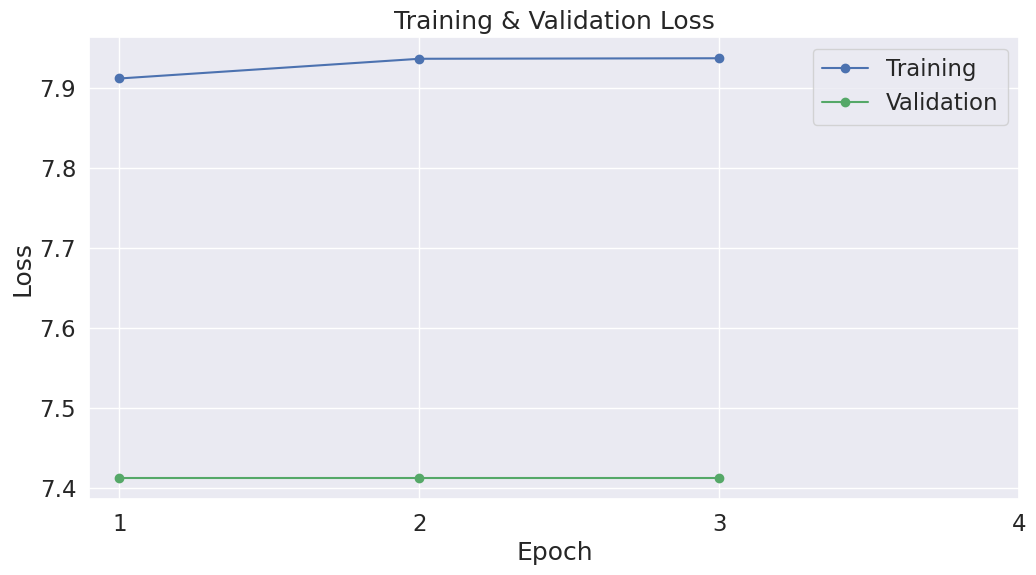

In [ ]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


There seems to be a problem. The model isn't learning anything and is overfitting. It may be a problem with the custom loss function too because the loss is increasing instead of decreasing.

In [ ]:
labels_test = torch.tensor(y_test.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(flat_true_labels, flat_predictions) # debug
print(accuracy)

flat_predictions

Predicting labels for 1,298 test sentences...
    DONE.
0.0007704160246533128


array([21, 55, 11, ..., 55, 55, 55])

In [ ]:
np.unique(flat_predictions, return_counts=True)

(array([11, 19, 21, 22, 31, 55]), array([ 159,    2,   76,    2,    2, 1057]))

## Investigating

In order to verify whether the model is just "memorizing responses," I take the same test dataset, and deliberately use inaccurate labels. If I still get the same responses, the model is overfitting.

In [ ]:
x_test_2 = asap_train.iloc[test_indices,]["essay"]
asap_train['domain1_score_altered'] = np.where(asap_train.domain1_score.index % 2==0, asap_train.domain1_score-1,asap_train.domain1_score)
y_test_2 = asap_train.iloc[test_indices,]["domain1_score_altered"]

In [ ]:
labels_test_2 = torch.tensor(y_test_2.values)
prediction_data_test_2 = TensorDataset(input_ids_test, attention_masks_test, labels_test_2)
prediction_sampler_test_2 = SequentialSampler(prediction_data_test_2)
prediction_dataloader_test_2 = DataLoader(prediction_data_test_2, sampler=prediction_sampler_test_2, batch_size=batch_size)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()
predictions, true_labels = [], []

for batch in prediction_dataloader_test_2:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions_2 = np.concatenate(predictions, axis=0)
flat_predictions_2 = np.argmax(flat_predictions_2, axis=1).flatten()
flat_true_labels_2 = np.concatenate(true_labels, axis=0)
np.unique(flat_predictions_2, return_counts=True)

Predicting labels for 1,298 test sentences...
    DONE.


(array([11, 19, 21, 22, 31, 55]), array([ 159,    2,   76,    2,    2, 1057]))

It is definitely just memorizing responses.

# Test Dataset Comparisons

I can still run the code to see what happens to the test dataset and then compare it with the ELL test dataset.

In [ ]:
prediction_data_ell_test = TensorDataset(input_ids_ell, attention_masks_ell)
prediction_sampler_ell_test = SequentialSampler(prediction_data_ell_test)
prediction_dataloader_ell_test = DataLoader(prediction_data_ell_test, sampler=prediction_sampler_ell_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model.eval()
predictions_ell_test = []

for batch in prediction_dataloader_ell_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions_ell_test.append(logits)

flat_predictions_ell = np.concatenate(predictions_ell_test, axis=0)

flat_predictions_ell = np.argmax(flat_predictions_ell, axis=1).flatten()
flat_predictions_ell

array([55, 55, 55, 55, 22, 55, 55, 21, 55, 21, 55, 21, 55, 55, 55, 21, 55,
       55, 55, 55, 11, 21, 21, 21, 55, 55, 55, 55, 55, 22, 22, 21, 21, 55,
       11, 11, 55, 21, 55, 55, 55, 31, 21, 21, 21, 55, 55, 55, 55, 55, 55,
       55, 55, 21, 55, 21, 21, 55, 21, 21, 21, 21, 55, 55, 55, 11, 55, 55,
       55, 55, 11, 21, 55, 21, 11, 21, 55, 21, 55, 11, 21, 55, 55, 55, 55,
       21, 55, 55, 21, 55, 55, 21, 55, 55, 55, 11, 55, 55, 11, 55, 21, 55,
       55, 21, 21, 55, 21, 55, 55, 21, 55, 11, 55, 55, 21, 55, 11, 21, 55,
       21, 55, 21, 21, 55, 55, 55, 21, 55, 55, 21, 11, 21, 21, 55, 21, 21,
       11, 21, 11, 55, 21, 55, 21, 21, 21, 55, 55, 55, 55, 55, 55, 21, 11,
       21, 55, 21, 55, 21, 55, 21, 11, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       11, 55, 55, 21, 11, 55, 55, 55, 22, 21, 21, 55, 11, 55, 55, 21, 21,
       55, 21, 21, 55, 11, 55, 55, 55, 55, 21, 55, 55, 55, 21, 55, 55, 55,
       55, 55, 21, 55, 21, 55, 55, 55, 11, 55, 55, 55, 55, 21, 11, 55, 55,
       21, 55, 55, 55, 55

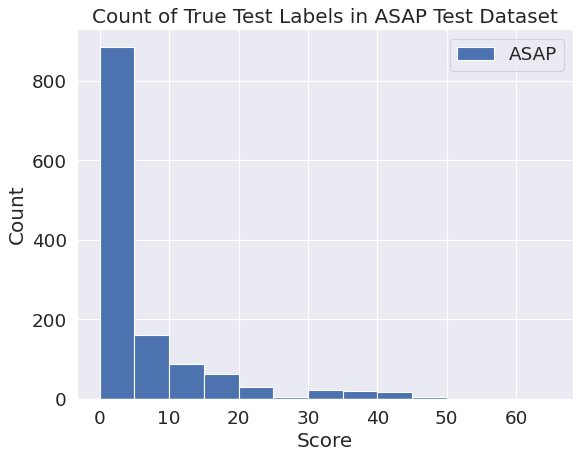

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(flat_true_labels, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Count of True Test Labels in ASAP Test Dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

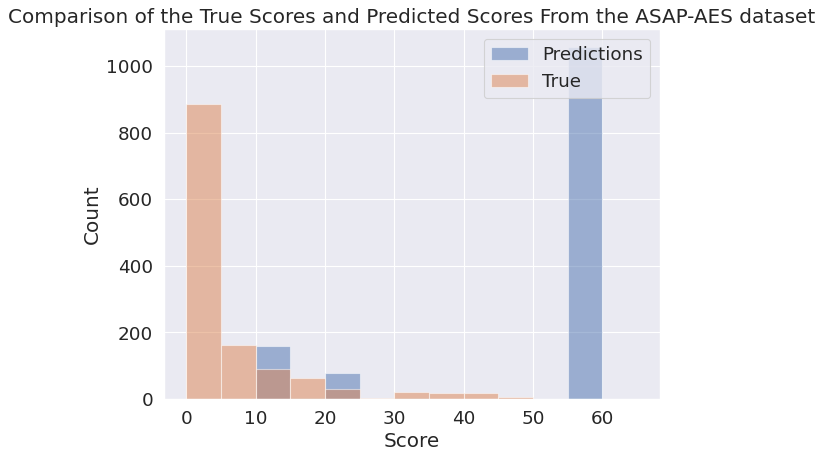

In [ ]:
predictions_asap = flat_predictions.tolist()
predictions_ell = flat_predictions_ell.tolist()

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='Predictions', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(flat_true_labels, alpha=0.5, label='True', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of the True Scores and Predicted Scores From the ASAP-AES dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Most of the predicted results are 55: much higher than the true values that have a right skew.

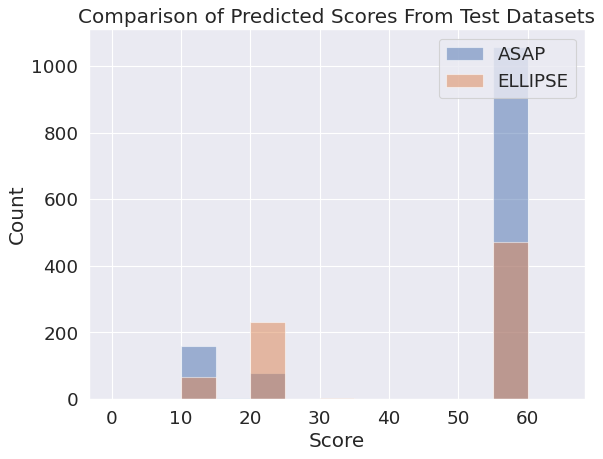

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(predictions_ell, alpha=0.5, label='ELLIPSE', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of Predicted Scores From Test Datasets')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The model only seems to be able to predict the same values for both datasets: providing another piece of evidence that the model is only memorizing the results.

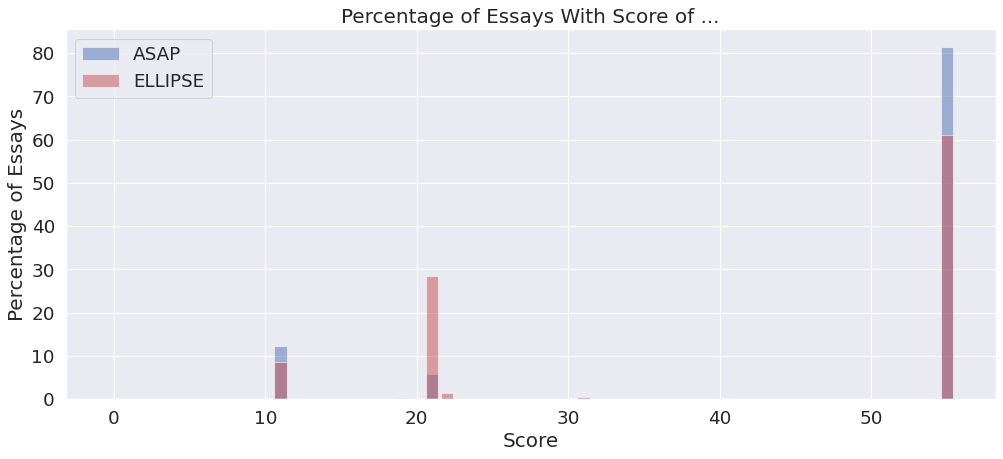

In [ ]:
asap_test_dict = {}
for score in predictions_asap:
  if score not in asap_test_dict.keys():
    asap_test_dict[score] = 0
  asap_test_dict[score] += 1

asap_test_dict_percentage = {}
num_asap_predictions = len(predictions_asap)

for i in range(max(predictions_asap)+1):
  if i not in asap_test_dict.keys():
    asap_test_dict_percentage[i] = 0
  else:
    asap_test_dict_percentage[i] = (asap_test_dict[i]/num_asap_predictions)*100

ell_test_dict = {}
for score in predictions_ell:
  if score not in ell_test_dict.keys():
    ell_test_dict[score] = 0
  ell_test_dict[score] += 1

ell_test_dict_percentage = {}
num_ell_predictions = len(predictions_ell)

for i in range(max(predictions_ell)+1):
  if i not in ell_test_dict.keys():
    ell_test_dict_percentage[i] = 0
  else:
    ell_test_dict_percentage[i] = (ell_test_dict[i]/num_ell_predictions)*100

a = list(asap_test_dict_percentage.keys())
b = list(asap_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_asap'] = b

asap_test_df = pd.DataFrame(data = empty)

a = list(ell_test_dict_percentage.keys())
b = list(ell_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_ell'] = b

ell_test_df = pd.DataFrame(data = empty)

percentages = asap_test_df.merge(ell_test_df, on=['score'], how='outer')

width = 0.8
plt.figure(figsize=(15, 6), dpi=80)

plt.bar(percentages['score'], percentages['percentage_of_asap'], width=width,
        color='b', label='ASAP', alpha=0.5)
plt.bar(percentages['score'], percentages['percentage_of_ell'],
        width=width, color='r', alpha=0.5, label='ELLIPSE')

plt.legend()
plt.xlabel('Score')
plt.ylabel('Percentage of Essays')
plt.title('Percentage of Essays With Score of ...')
plt.show()

In [ ]:
from scipy.stats import ttest_ind
t_statistic, p_value = ttest_ind(predictions_asap, predictions_ell)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t-statistic: 8.675032690793735
P-value: 8.206497776422926e-18


# Updating Batch-Size

According to [stackexchange](https://datascience.stackexchange.com/questions/43191/validation-loss-is-not-decreasing), I can try to increase the training data, adjust the batch-size, or add dropout layers.

I can't increase the training data because I don't have access to the validation or test datasets from the competition. If I add other essays to the model, I'm further increasing the complexity to the scoring system. The scores aren't consistent amongst the essay sets, no need to add in another set that further complicates matters.

I can't add a dropout layer. According to the [source documentation](https://huggingface.co/transformers/v2.11.0/model_doc/bert.html?highlight=bertforsequenceclassification#bertforsequenceclassification), the model is a "Bert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output)". Each of the BERT dense layers already has a dropout layer. This is only adding a classification layer on top, not adding more dense layers, thus there is no need to add a dropout layer in the first place.

Thus, I am left with adjusting the batch-size. I decided to decrease it down to 8 to see what happens.

In [ ]:
batch_size = 8

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [ ]:
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
training_stats = []

for epoch_i in range(0, epochs):
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        modt = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        logits=modt['logits']
        most_likely = torch.argmax(logits, dim=1).flatten()
        most_likely = most_likely.float()
        most_likely.requires_grad = True
        b_labels = b_labels.long()
        loss = loss_fn(most_likely, b_labels)
        loss.requires_grad = True
        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            modv = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            logits = modv['logits']
            most_likely = torch.argmax(logits, dim=1).flatten()
            most_likely = most_likely.float()
            most_likely.requires_grad = True
            b_labels = b_labels.long()
            loss = loss_fn(most_likely, b_labels)
            # loss.requires_grad = True

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print("  Validation Loss: {0:.5f}".format(avg_val_loss))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss
        }
    )

print("")
print("Training complete!")


  Average training loss: 5.68506
  Validation Loss: 4.18943

  Average training loss: 5.67211
  Validation Loss: 4.18943

  Average training loss: 5.69084
  Validation Loss: 4.18943

Training complete!


In [ ]:
pd.set_option('display.precision', 5)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss
epoch,,
1,5.68506,4.18943
2,5.67211,4.18943
3,5.69084,4.18943


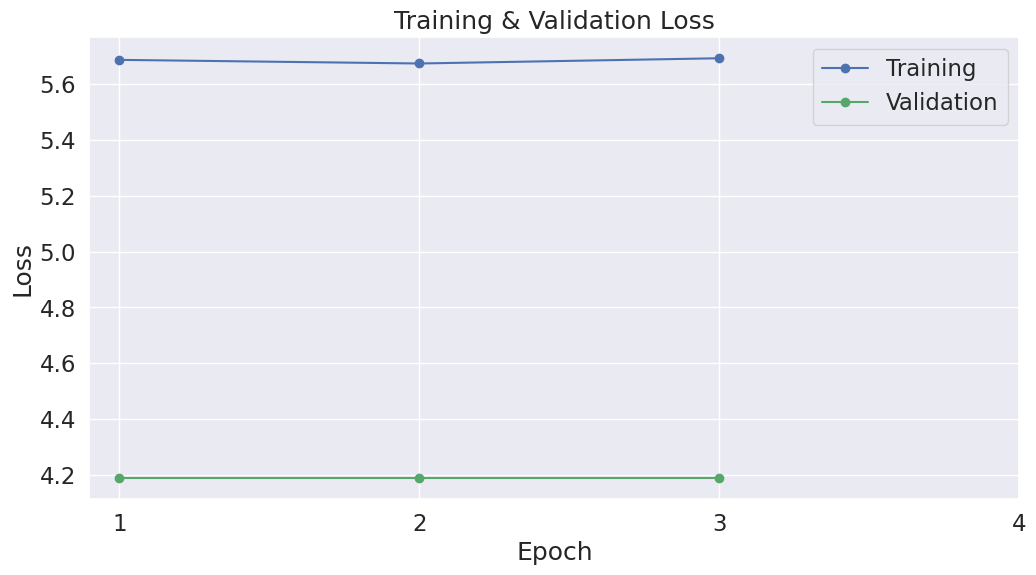

In [ ]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

While the loss is less, it's still overfitting and the model is still only memorizing the results.

In [ ]:
labels_test = torch.tensor(y_test.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(flat_true_labels, flat_predictions) # debug
print(accuracy)

flat_predictions

Predicting labels for 1,298 test sentences...
    DONE.
0.0007704160246533128


array([21, 55, 11, ..., 55, 55, 55])

In [ ]:
np.unique(flat_predictions, return_counts=True)

(array([11, 19, 21, 22, 31, 55]), array([ 159,    2,   76,    2,    2, 1057]))

The same values are predicted.

In [ ]:
x_test_2 = asap_train.iloc[test_indices,]["essay"]
asap_train['domain1_score_altered'] = np.where(asap_train.domain1_score.index % 2==0, asap_train.domain1_score-1,asap_train.domain1_score)
y_test_2 = asap_train.iloc[test_indices,]["domain1_score_altered"]

labels_test_2 = torch.tensor(y_test_2.values)
prediction_data_test_2 = TensorDataset(input_ids_test, attention_masks_test, labels_test_2)
prediction_sampler_test_2 = SequentialSampler(prediction_data_test_2)
prediction_dataloader_test_2 = DataLoader(prediction_data_test_2, sampler=prediction_sampler_test_2, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()
predictions, true_labels = [], []

for batch in prediction_dataloader_test_2:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions_2 = np.concatenate(predictions, axis=0)
flat_predictions_2 = np.argmax(flat_predictions_2, axis=1).flatten()
flat_true_labels_2 = np.concatenate(true_labels, axis=0)
np.unique(flat_predictions_2, return_counts=True)

Predicting labels for 1,298 test sentences...
    DONE.


(array([11, 19, 21, 22, 31, 55]), array([ 159,    2,   76,    2,    2, 1057]))

It's just memorizing responses again.